In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library(dplyr)
library(scales)
library(grid)
library(ggplot2)
library(gridExtra)
library(magrittr)
library(readr)

In [5]:
%%R
qPCR = read_csv("data/AfaDVload.csv")

qPCR = dplyr::tbl_df(qPCR)

dplyr::glimpse(qPCR)

Observations: 254
Variables: 15
$ SampleName         <chr> "AF1", "AF2", "AF3", "AF4", "AF5", "AF6", "SML14...
$ Species            <chr> "Asterias forbesi", "Asterias forbesi", "Asteria...
$ CommonName         <chr> "Forbes Star", "Forbes Star", "Forbes Star", "Fo...
$ CollectionLocation <chr> "Nahant, MA", "Nahant, MA", "Nahant, MA", "Nahan...
$ CollectionDate     <chr> "23-Sep-15", "23-Sep-15", "23-Sep-15", "23-Sep-1...
$ CollectionYear     <int> 2015, 2015, 2015, 2015, 2015, 2015, 2016, 2016, ...
$ Health             <chr> "Symptomatic", "Symptomatic", "Symptomatic", "Sy...
$ AnimalSize         <dbl> NA, NA, NA, NA, NA, NA, 8.5, 8.5, 8.5, 8.0, 10.5...
$ SampleType         <chr> NA, NA, NA, NA, NA, NA, "PC", "G", "E", "PC", "P...
$ SampleAmount       <chr> "65 mg", "65 mg", "65 mg", "65 mg", "65 mg", "65...
$ Elution            <chr> "30 ul", "30 ul", "30 ul", "30 ul", "30 ul", "30...
$ viralload          <dbl> 1122.02, 3683.19, 5648.92, 5855.82, 1852.98, 146...
$ standarderror     

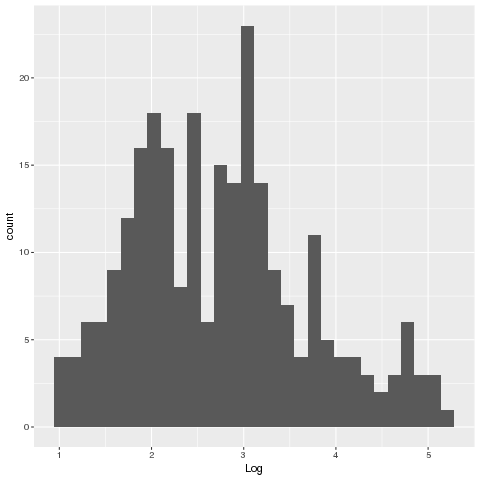

In [7]:
%%R
##Checking for normality
p = ggplot(qPCR, aes(x=Log)) + geom_histogram()
p

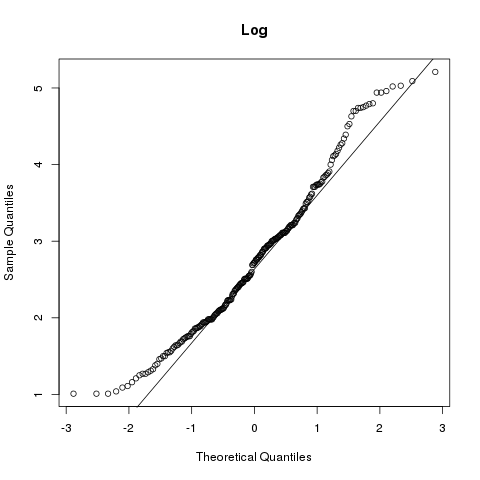

In [12]:
%%R
##Checking for normality
q = qqnorm(qPCR$Log,main="Log")
qqline(qPCR$Log)

In [9]:
%%R
qPCR.aov = aov(Log~Species,data=qPCR)
summary(qPCR.aov)

             Df Sum Sq Mean Sq F value   Pr(>F)    
Species       2  19.66   9.829    11.6 1.52e-05 ***
Residuals   251 212.73   0.848                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


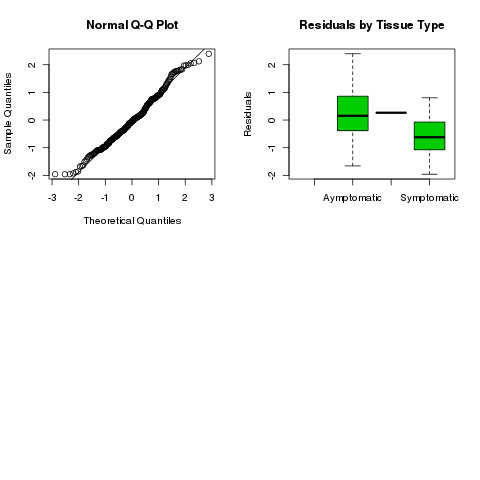

In [6]:
%%R
par(mfrow=c(2,2))

q = qqnorm(resid(qPCR.aov),cex=1.2)
qqline(resid(qPCR.aov))

p = boxplot(split(resid(qPCR.aov),qPCR$Health),ylab="Residuals",col=3)
title("Residuals by Tissue Type")

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Log ~ Species, data = qPCR)

$Species
                                         diff         lwr        upr     p adj
Asterias vulgaris-Asterias forbesi -0.6207936 -0.92583000 -0.3157572 0.0000082
Henricia-Asterias forbesi          -0.1526700 -0.56736943  0.2620294 0.6609859
Henricia-Asterias vulgaris          0.4681236  0.02292926  0.9133179 0.0367070



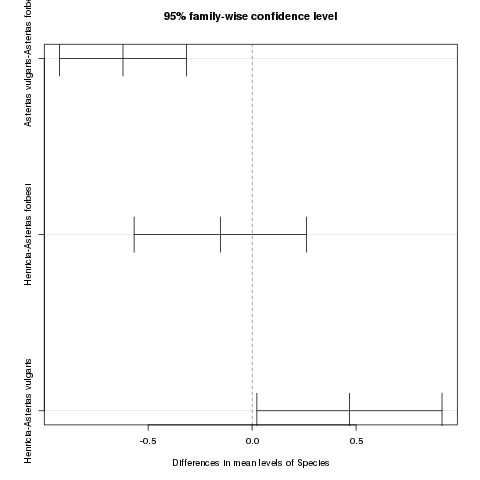

In [10]:
%%R
T = TukeyHSD(qPCR.aov)
par(cex=.75)
plot(TukeyHSD(qPCR.aov))  
T

In [12]:
%%R
qPCRsummary = qPCR %>%
 group_by(SampleType) %>%
 summarise(avg = mean(Log), sd = sd(Log), sem = sd(Log)/sqrt(length(Log))) %>%
 arrange(desc(avg))

qPCRsummary

# A tibble: 4 × 4
  SampleType      avg        sd        sem
       <chr>    <dbl>     <dbl>      <dbl>
1       <NA> 3.358077 0.7981530 0.15653067
2         PC 3.221667 1.0268926 0.10824399
3          E 2.430000 0.7399120 0.07932689
4          G 2.172745 0.6322945 0.08853894


In [14]:
%%R
qPCRsummary2 = qPCR %>%
 group_by(Health) %>%
 summarise(avg = mean(Log), sd = sd(Log), sem = sd(Log)/sqrt(length(Log))) %>%
 arrange(desc(avg))

#limits = aes(ymax = quantity + sem, ymin=quantity - sem)

#p = ggplot(p, aes(Sample_Type,avg)) + geom_bar(stat="identity")# + geom_errorbar()

qPCRsummary2

# A tibble: 2 × 4
       Health      avg        sd        sem
        <chr>    <dbl>     <dbl>      <dbl>
1 Aymptomatic 2.958539 0.9790086 0.07337979
2 Symptomatic 2.274474 0.7100730 0.08145096


In [15]:
%%R
qPCRsummary3 = qPCR %>%
 group_by(Species) %>%
 summarise(avg = mean(Log), sd = sd(Log), sem = sd(Log)/sqrt(length(Log))) %>%
 arrange(desc(avg))

#limits = aes(ymax = quantity + sem, ymin=quantity - sem)

#p = ggplot(p, aes(Sample_Type,avg)) + geom_bar(stat="identity")# + geom_errorbar()

qPCRsummary3

# A tibble: 3 × 4
            Species      avg        sd        sem
              <chr>    <dbl>     <dbl>      <dbl>
1  Asterias forbesi 2.967376 1.0402573 0.08760547
2          Henricia 2.814706 0.8540749 0.14647263
3 Asterias vulgaris 2.346582 0.6901911 0.07765257


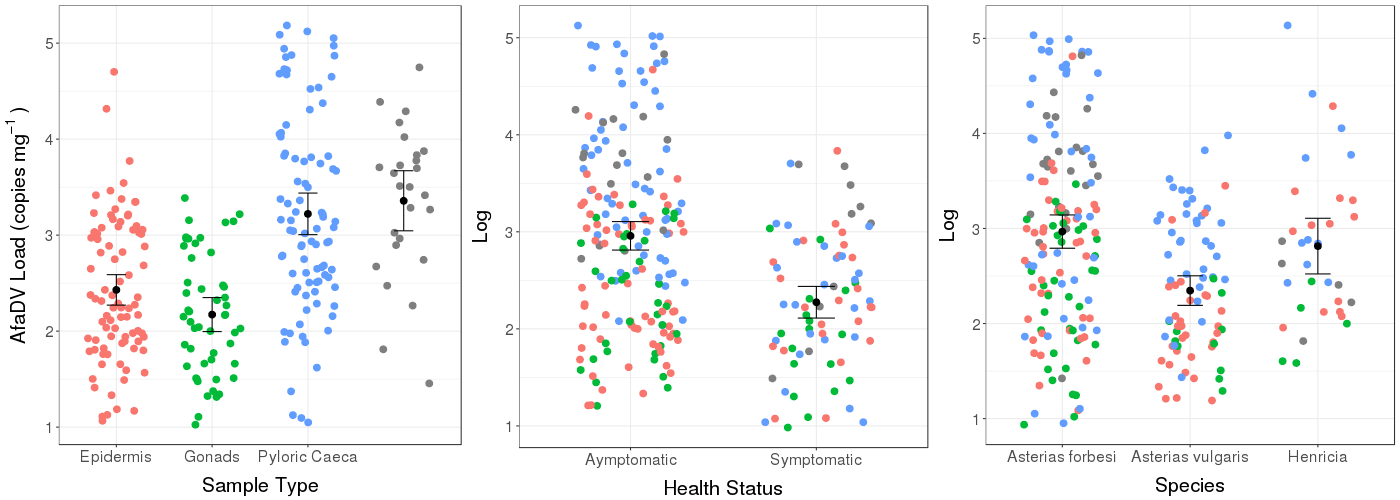

In [16]:
%%R -w 1400 -h 500
####Plot 1#####
p = ggplot(qPCR, aes(x = SampleType,y = Log), color = factor(SampleType))

p = p + geom_point(aes(y = Log, color = factor(SampleType)), size = 3, 
                   position = position_jitter(width = 0.3, height = 0.1))

p = p + geom_point(aes(y = avg), color = "black", size = 3, data = qPCRsummary) + 
  geom_errorbar(aes(y = avg, ymin = avg-(2*sem), ymax = avg+(2*sem)), 
                color = "black", width = 0.2, data = qPCRsummary)

p = p + ylab(bquote('AfaDV Load (copies' ~ mg^-1~')')) + xlab("Sample Type")

p = p + theme_bw() + theme(text=element_text(size=20, color="black"),
                           #panel.grid.major = element_blank(),
                           #panel.grid.minor = element_blank(),
                           legend.position="none",
                           axis.title.y=element_text(margin=margin(0,15,0,0)),
                           axis.title.x=element_text(margin=margin(15,0,0,0)))

p = p + scale_x_discrete(breaks=c("E", "G", "PC"), labels=c("Epidermis", "Gonads", "Pyloric Caeca"))


p

####Plot 2#####
p2 = ggplot(qPCR, aes(x = Health,y = Log), color = factor(Health))

p2 = p2 + geom_point(aes(y = Log, color = factor(SampleType)), size = 3, 
                   position = position_jitter(width = 0.3, height = 0.1))

p2 = p2 + geom_point(aes(y = avg), color = "black", size = 3, data = qPCRsummary2) + 
  geom_errorbar(aes(y = avg, ymin = avg-(2*sem), ymax = avg+(2*sem)), 
                color = "black", width = 0.2, data = qPCRsummary2)

p2 = p2 + xlab("Health Status")

p2 = p2 + theme_bw() + theme(text=element_text(size=20, color="black"),
                           #panel.grid.major = element_blank(),
                           #panel.grid.minor = element_blank(),
                           legend.position="none",
                           #axis.text.y=element_blank(), 
                           axis.title.y=element_text(margin=margin(0,15,0,0)),
                           axis.title.x=element_text(margin=margin(15,0,0,0)))


p2

####Plot 3#####
p3 = ggplot(qPCR, aes(x = Species,y = Log), color = factor(Log))

p3 = p3 + geom_point(aes(y = Log, color = factor(SampleType)), size = 3, 
                   position = position_jitter(width = 0.3, height = 0.1))

p3 = p3 + geom_point(aes(y = avg), color = "black", size = 3, data = qPCRsummary3) +
    geom_errorbar(aes(y = avg, ymin = avg-(2*sem), ymax = avg+(2*sem)), 
                color = "black", width = 0.2, data = qPCRsummary3)

#p3 = p3 + stat_summary(fun.y = mean, fun.ymin = mean, fun.ymax = mean, geom = "crossbar", width = 0.5)

p3 = p3 + xlab("Species")

p3 = p3 + theme_bw() + theme(text=element_text(size=20, color="black"),
                           #panel.grid.major = element_blank(),
                           #panel.grid.minor = element_blank(),
                           legend.position="none",
                           #axis.text.y=element_blank(),
                           axis.title.y=element_text(margin=margin(0,15,0,0)),
                           axis.title.x=element_text(margin=margin(15,0,0,0)))


p3

gridExtra::grid.arrange(nrow=1, p, p2,p3)

In [20]:
%%R
qPCRsummary4 = qPCR %>%
 group_by(CollectionYear) %>%
 summarise(avg = mean(Log), sd = sd(Log), sem = sd(Log)/sqrt(length(Log))) %>%
 arrange(desc(avg))

#limits = aes(ymax = quantity + sem, ymin=quantity - sem)

#p = ggplot(p, aes(Sample_Type,avg)) + geom_bar(stat="identity")# + geom_errorbar()

qPCRsummary4

# A tibble: 6 × 4
  CollectionYear      avg        sd        sem
           <int>    <dbl>     <dbl>      <dbl>
1           2015 3.430000 0.3082856 0.12585706
2           2016 2.865850 0.9739260 0.06886697
3           2012 2.352143 0.6174990 0.09528217
4           2013 1.330000        NA         NA
5             NA 1.150000 0.2092845 0.10464225
6           2014 1.010000        NA         NA


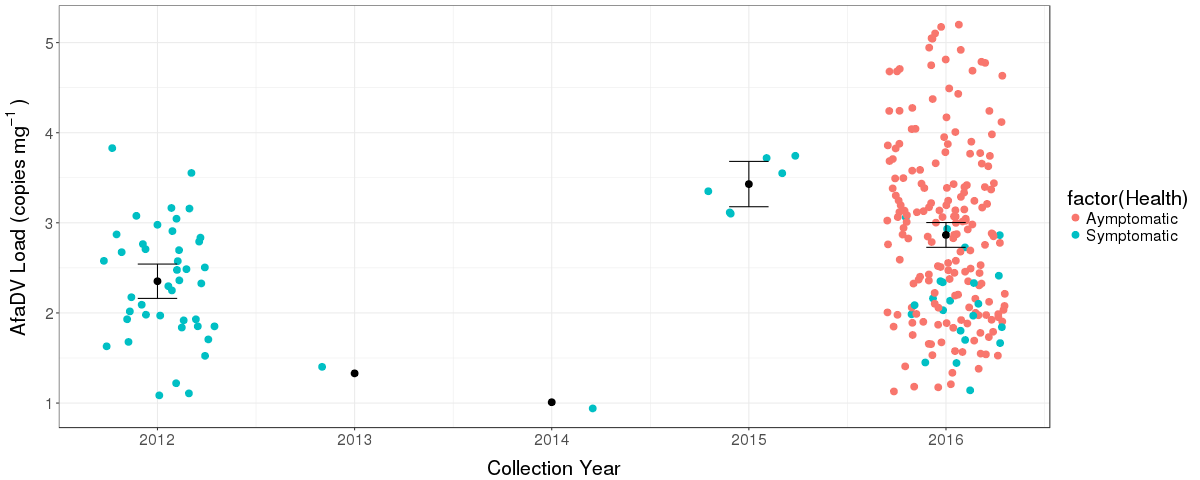

In [80]:
%%R -w 1200
####Plot 1#####
p = ggplot(qPCR, aes(x = CollectionYear,y = Log), color = factor(Health))

p = p + geom_point(aes(y = Log, color = factor(Health)), size = 3, 
                   position = position_jitter(width = 0.3, height = 0.1))

p = p + geom_point(aes(y = avg), color = "black", size = 3, data = qPCRsummary4) + 
  geom_errorbar(aes(y = avg, ymin = avg-(2*sem), ymax = avg+(2*sem)), 
                color = "black", width = 0.2, data = qPCRsummary4)

p = p + ylab(bquote('AfaDV Load (copies' ~ mg^-1~')')) + xlab("Collection Year")

p = p + theme_bw() + theme(text=element_text(size=20, color="black"),
                           #panel.grid.major = element_blank(),
                           #panel.grid.minor = element_blank(),
                           #legend.position="none",
                           axis.title.y=element_text(margin=margin(0,15,0,0)),
                           axis.title.x=element_text(margin=margin(15,0,0,0)))

p

In [62]:
%%R
qPCR.lm = lm(Log ~ AnimalSize, data = qPCR)
summary(qPCR.lm)
#coef(lm(Log ~ AnimalSize, data = qPCR))


Call:
lm(formula = Log ~ AnimalSize, data = qPCR)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.86752 -0.64974 -0.02865  0.50767  2.22777 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.89697    0.16889  23.074  < 2e-16 ***
AnimalSize  -0.15189    0.02431  -6.249  2.7e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8807 on 188 degrees of freedom
  (64 observations deleted due to missingness)
Multiple R-squared:  0.172,	Adjusted R-squared:  0.1676 
F-statistic: 39.05 on 1 and 188 DF,  p-value: 2.7e-09



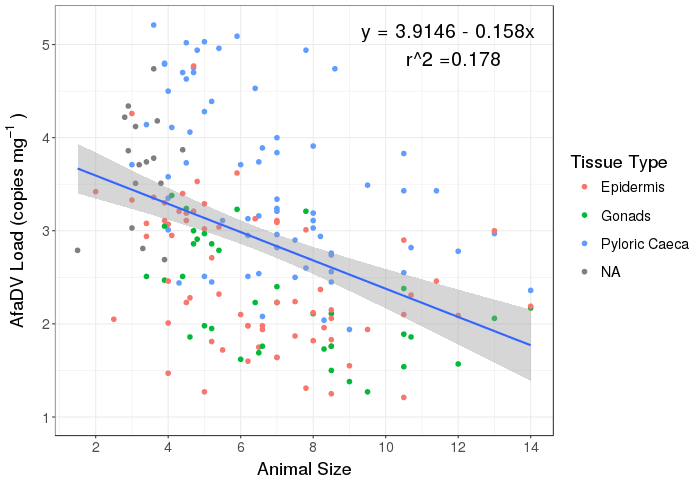

In [63]:
%%R -w 700

p = ggplot(qPCR, aes(x=AnimalSize, y=Log)) + geom_point(aes(colour = factor(SampleType)), size = 2)

p = p + geom_smooth(method=lm)

p = p + scale_x_continuous(breaks = c(2,4,6,8,10,12,14,16)) 

p = p + scale_color_discrete(name="Tissue Type",labels=c("Epidermis","Gonads","Pyloric Caeca"))

p = p + theme_bw() + theme(legend.key = element_blank(),
                           text=element_text(size=18),
                           axis.title.y=element_text(margin=margin(0,15,0,0)),
                           axis.title.x=element_text(margin=margin(10,0,0,0)),
                           legend.key.size = unit(1, "cm"))

p = p + ylab(bquote('AfaDV Load (copies' ~ mg^-1~')')) + xlab("Animal Size")

p = p + annotate("text", label = "y = 3.9146 - 0.158x \n r^2 =0.178", x = 11.8, y = 5, size = 7, colour = "black")

p

In [24]:
%%R
qPCRprev = read.csv("data/AfaDVprev.csv")

qPCRprev

  Tissue Absent Present Total Prevalence
1     CF     38       0    38       0.00
2      E     12      87    99       0.88
3      G     11      52    63       0.83
4     PC      6      90    96       0.94


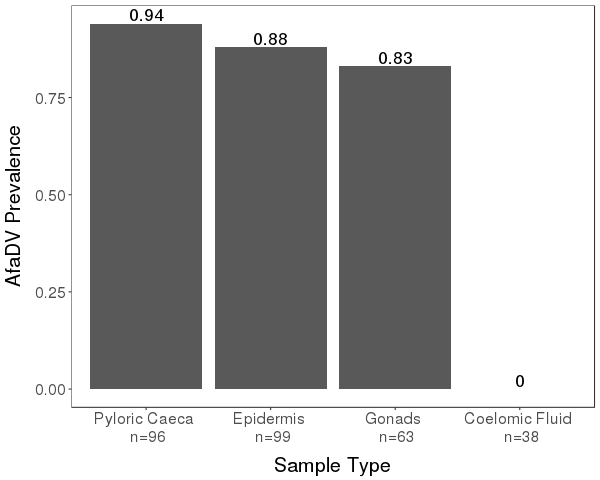

In [26]:
%%R -w 600

p = ggplot(qPCRprev, aes(x= reorder(Tissue,-Prevalence), y=Prevalence)) + geom_bar(stat="identity")

p = p + scale_x_discrete(breaks=c("E", "G", "PC","CF"),
                         labels=c("Epidermis \n n=99", "Gonads \n n=63", 
                                  "Pyloric Caeca \n n=96","Coelomic Fluid \n n=38"))


p = p + ylab("AfaDV Prevalence") + xlab("Sample Type") 

p = p + geom_text(aes(x=Tissue, y=Prevalence, ymax=Prevalence, label=Prevalence), vjust = -0.2, size=6) 

p = p + theme_bw() + theme(text=element_text(size=20, color="black"),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           axis.title.y=element_text(margin=margin(0,15,0,0)),
                           axis.title.x=element_text(margin=margin(15,0,0,0)))

p

In [18]:
%%R
qPCRtrans = read.csv("data/AfaDVtrans.csv")
qPCRtrans

RTqPCRsummary = qPCRtrans %>%
 group_by(SampleType) %>%
 summarise(avg = mean(viraltrans), sd = sd(viraltrans), sem = sd(viraltrans)/sqrt(length(viraltrans))) %>%
 arrange(desc(avg))

RTqPCRsummary


Error in withVisible({ : could not find function "%>%"


In [16]:
%%R
p = ggplot(qPCRtrans, aes(x = SampleType, y = viraltrans), color = factor(SampleType))

p = p + geom_point(aes(y = viraltrans, color = factor(SampleType)), size = 3, 
                   position = position_jitter(width = 0.3, height = 0.1))

p = p + geom_point(aes(y = avg), color = "black", size = 3, data = RTqPCRsummary) 
  
p = p + geom_errorbar(aes(y = avg, ymin = avg-sem, ymax = avg+sem), color = "black", width = 0.2, data = RTqPCRsummary)

p = p + scale_color_discrete(name="Tissue Type",labels=c("Epidermis","Pyloric Caeca"))

p = p + theme_bw() + theme(legend.key = element_blank(),
                           text=element_text(size=18),
                           axis.title.y=element_text(margin=margin(0,15,0,0)),
                           axis.title.x=element_text(margin=margin(10,0,0,0)),
                           legend.key.size = unit(1, "cm"))

p = p + ylab(bquote('AfaDV VP4 Transcripts (copies' ~ mg^-1~')')) + xlab("Sample Type")

p


Error in ggplot(qPCRtrans, aes(x = SampleType, y = viraltrans), color = factor(SampleType)) : 
  object 'qPCRtrans' not found


/opt/anaconda2/envs/fullCyc2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in ggplot(qPCRtrans, aes(x = SampleType, y = viraltrans), color = factor(SampleType)) : 
  object 'qPCRtrans' not found

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/envs/fullCyc2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/envs/fullCyc2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/envs/fullCyc2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 1: Removed 64 rows containing non-finite values (stat_smooth). 

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/envs/fullCyc2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 2: Removed 64 rows containing missing values (geom_point). 

  warnings.warn(x, RRuntimeWarning)